# Predicting house pricing

## Table of contents
<ul><font color=blue>
<li><a href="#problem">Question and problem definition</a></li>
<li><a href="#analyze">Analyze, identify patterns, and explore the data</a></li>
<li><a href="#model">Model, predict and solve the problem</a></li>
<li><a href="#conclusion">Report and present the problem solving steps and final solution</a></li>
</ul>


### Question and problem definition
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [61]:
#This code is to import the libraries we will ptentially be using during the execution of the tasks I have been assigned to
# data analysis and wrangling
import pandas as pd
import pickle
import numpy as np
import random as rnd
from datetime import timedelta
import scipy
from scipy import stats
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning and metrics
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, Lasso, SGDRegressor, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [62]:
#Import of data into dataframes called train_df and test-df respectively
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
#dropping ID column
train_df.drop(columns = 'Id', inplace =True)
test_df.drop(columns = 'Id', inplace =True)
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

<a id='analyze'></a>
### Analyze, identify patterns, and explore the data
In this session I will be looking much deeper into data trends, exploring their statistical distribution and eventually correcting outliers and nans
We will be exploring the dataset, visualizing data to uncover patterns, removing potential outliers and correcting for missing values

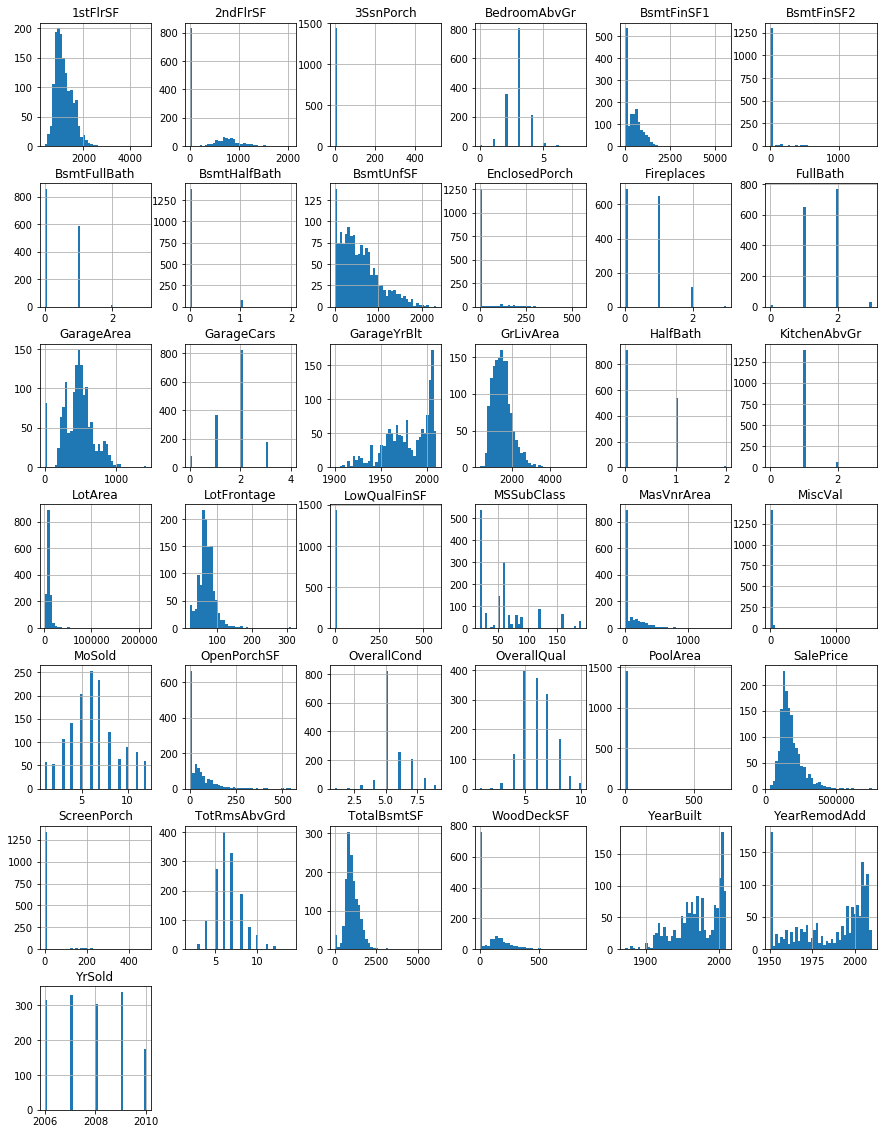

In [63]:
#let's have an idea of statistics and plot the data distribution for training dataset
train_df.describe()
train_df.hist(bins = 40, figsize=(15,20));

#### A lot of data do not follow a normal distribution

In [64]:
#creating 2 separated lists for numeric and categorical features
categorical_features = [f for f in train_df.columns if train_df.dtypes[f] == 'object']
numberical_features = [f for f in train_df.columns if train_df.dtypes[f] != 'object']

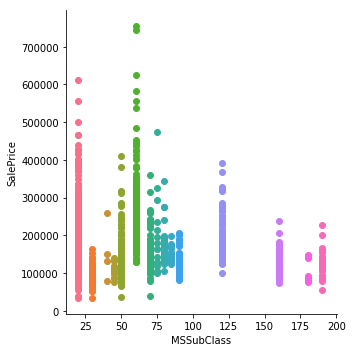

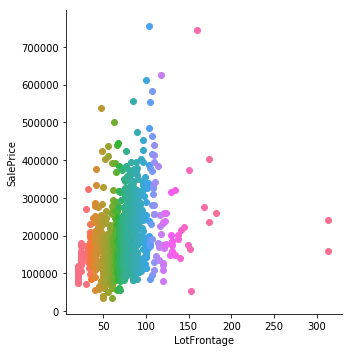

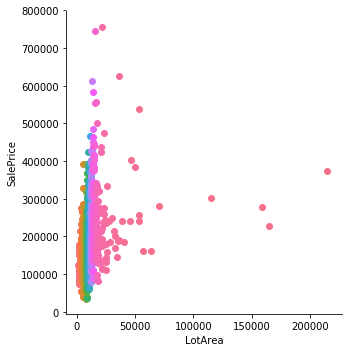

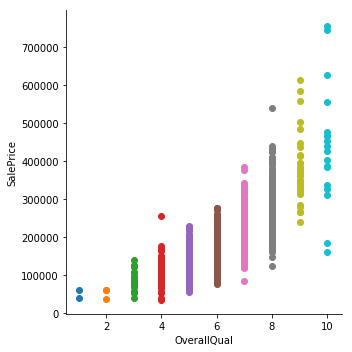

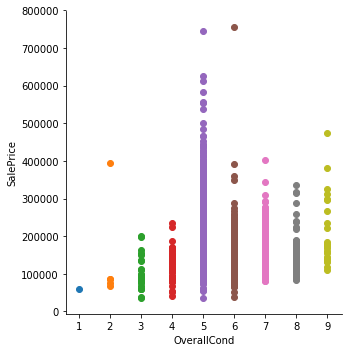

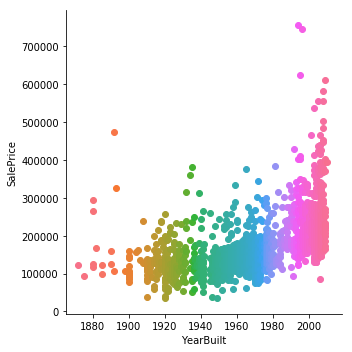

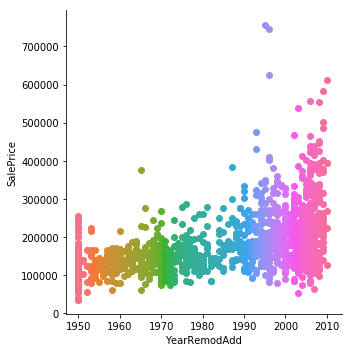

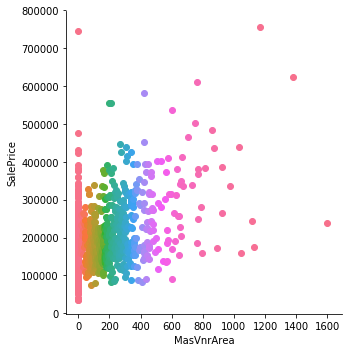

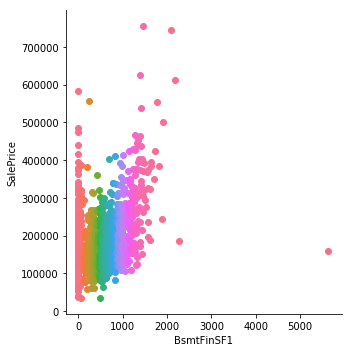

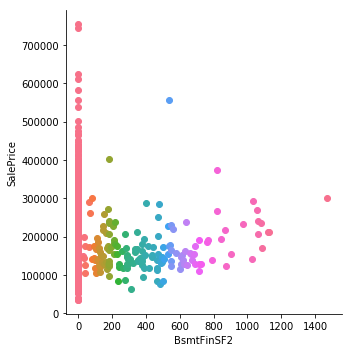

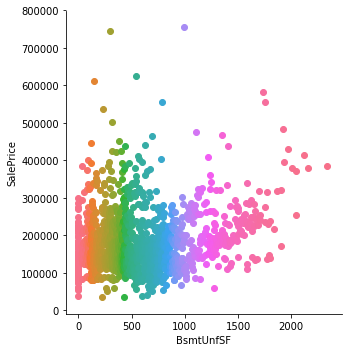

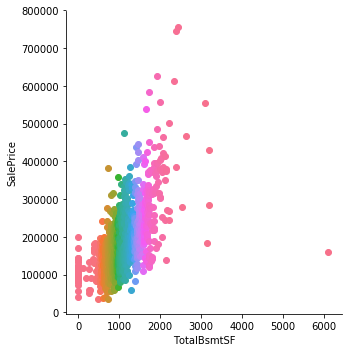

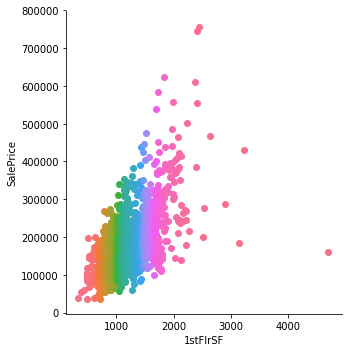

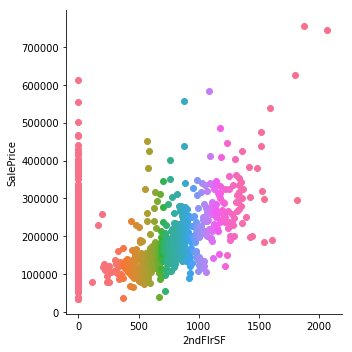

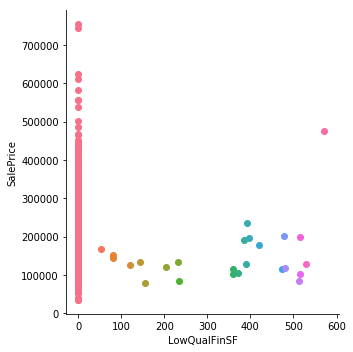

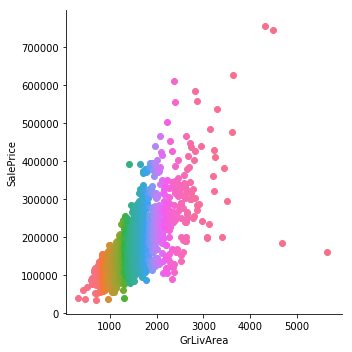

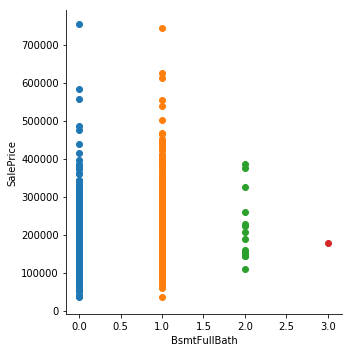

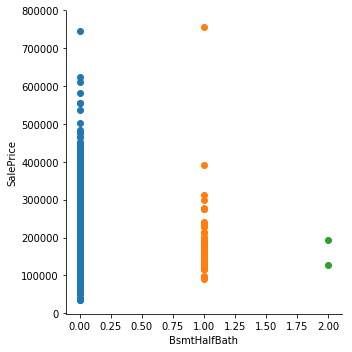

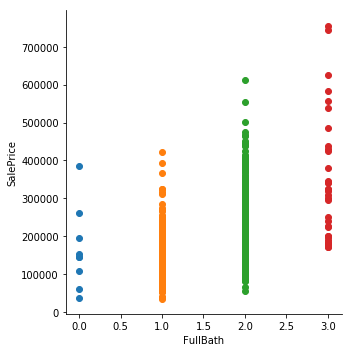

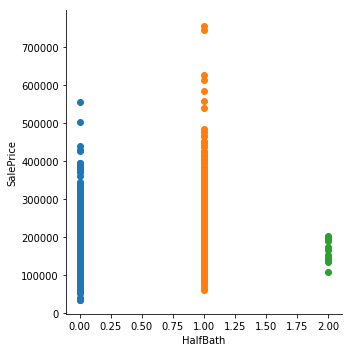

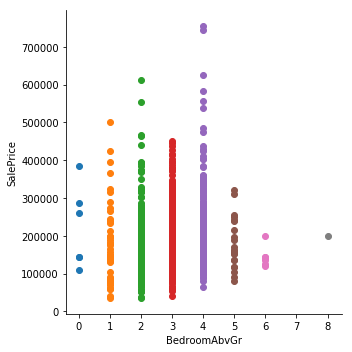

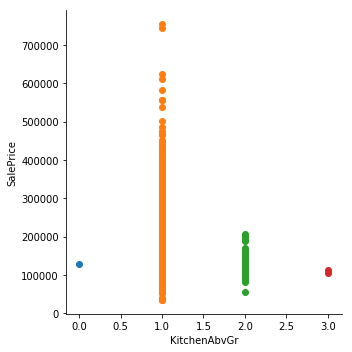

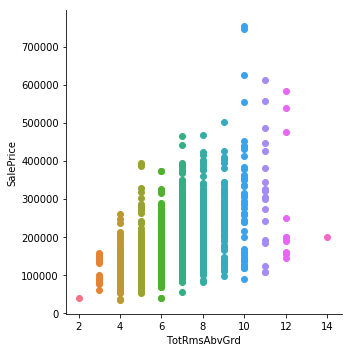

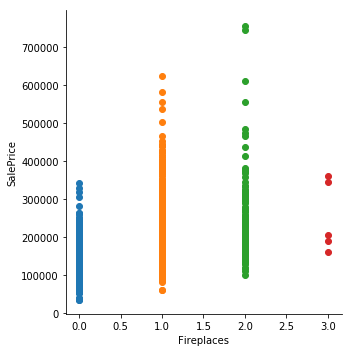

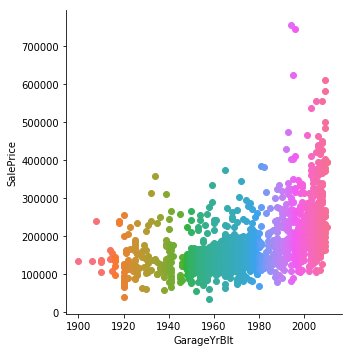

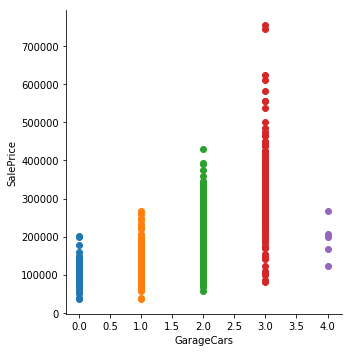

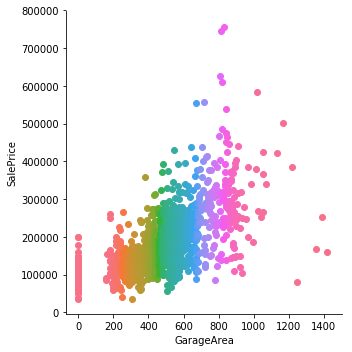

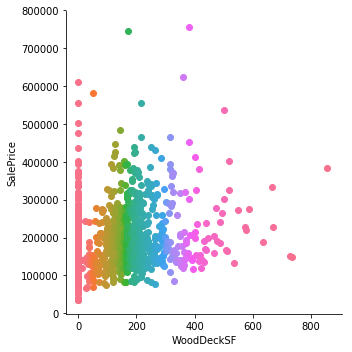

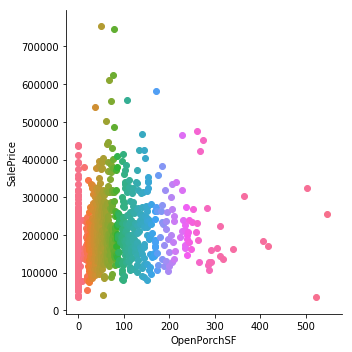

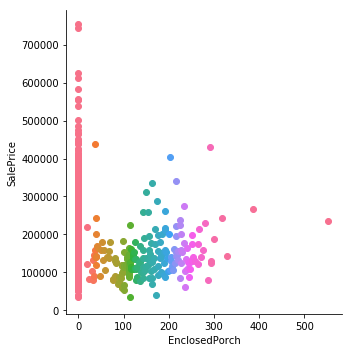

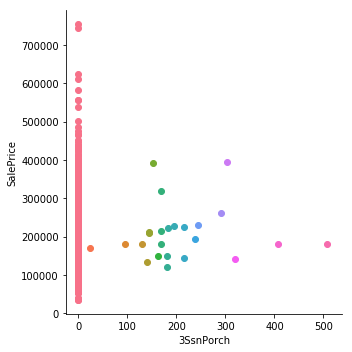

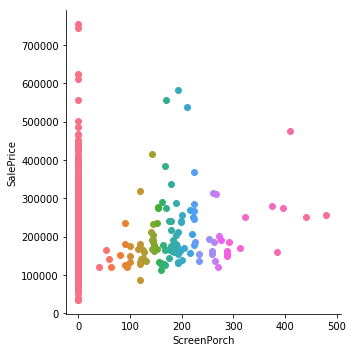

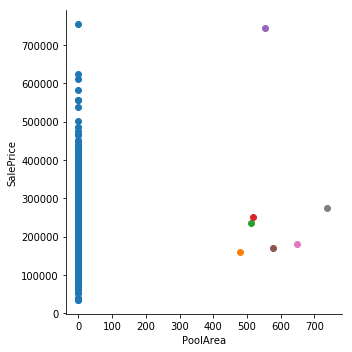

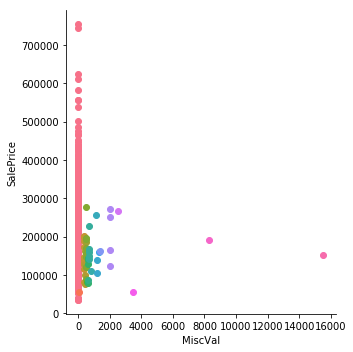

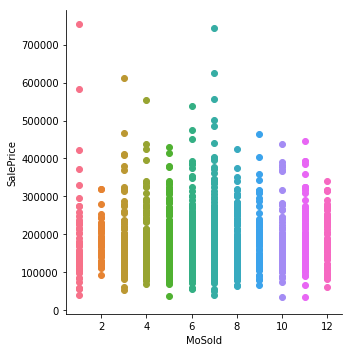

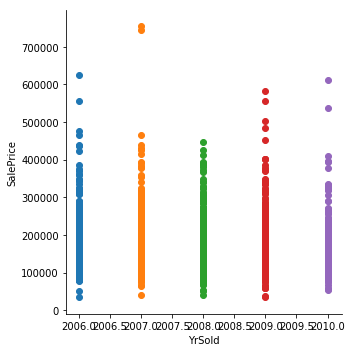

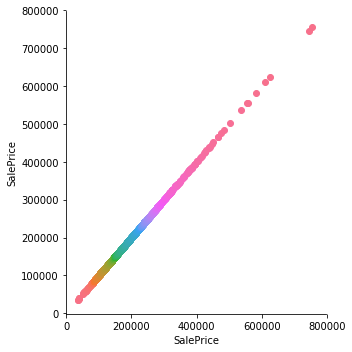

In [65]:
# Scatter plot for numeric features vs House sale price
for i in numberical_features:
    sns.FacetGrid(train_df, hue=i, size=5).map(plt.scatter, i, "SalePrice") 
plt.show()

In [66]:
#removing outliers
train_df.drop(train_df[train_df['TotalBsmtSF'] > 5000].index,inplace = True)
train_df.drop(train_df[train_df['1stFlrSF'] > 4000].index,inplace = True)
train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice']<300000)].index,inplace = True)

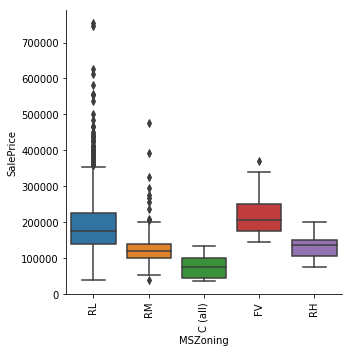

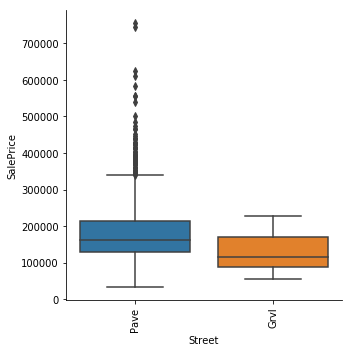

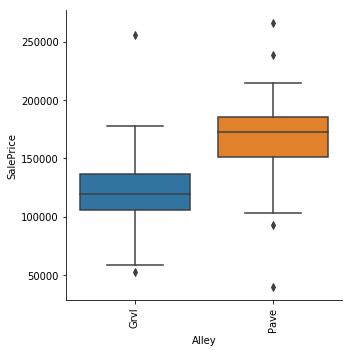

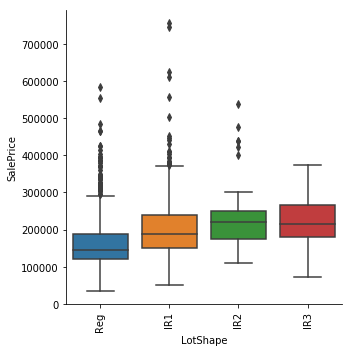

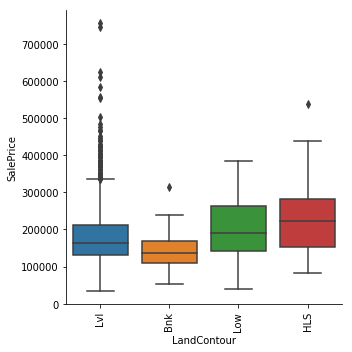

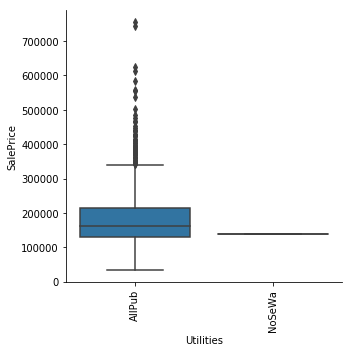

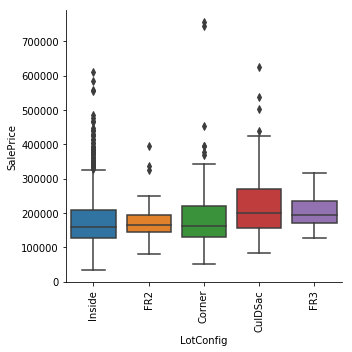

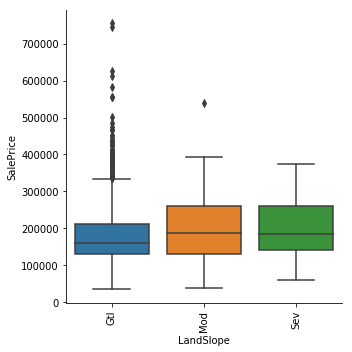

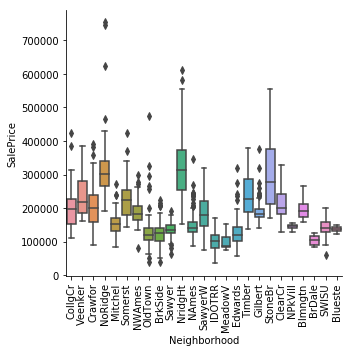

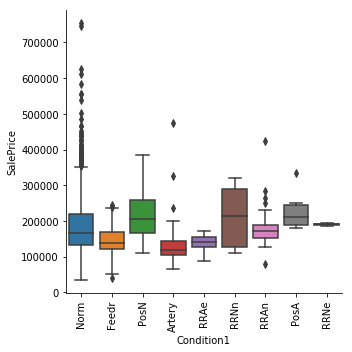

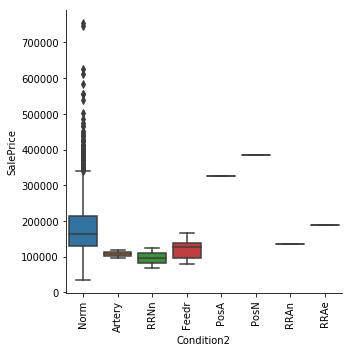

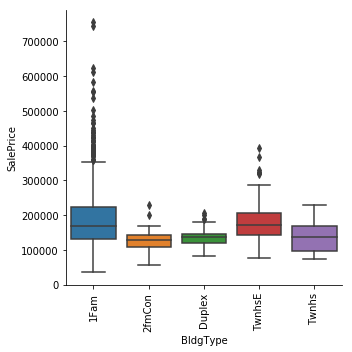

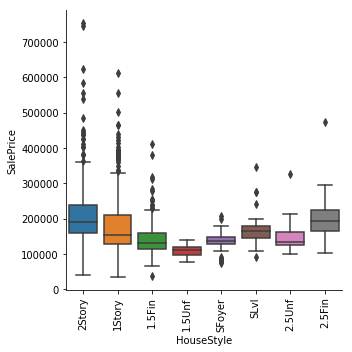

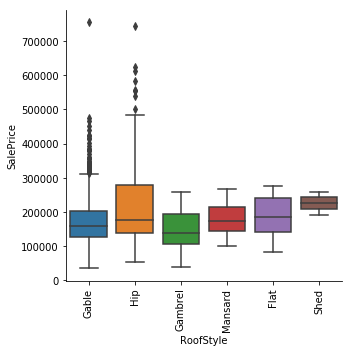

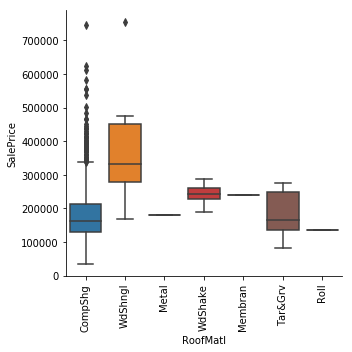

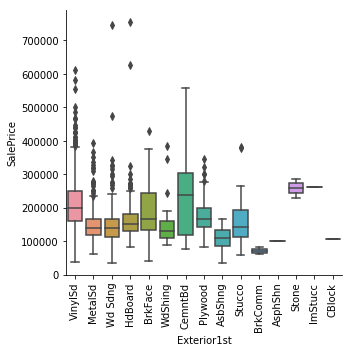

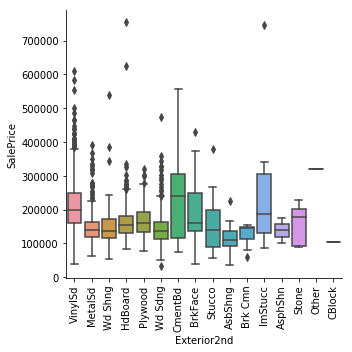

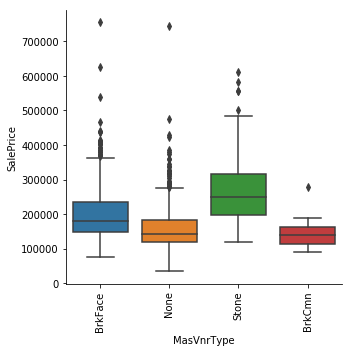

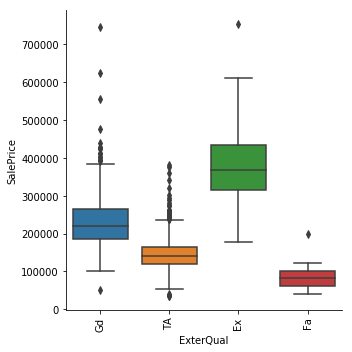

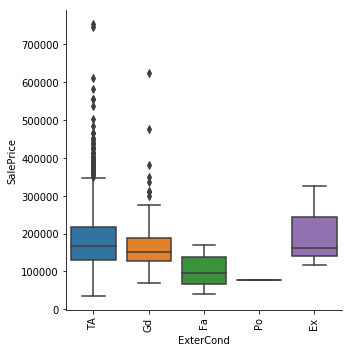

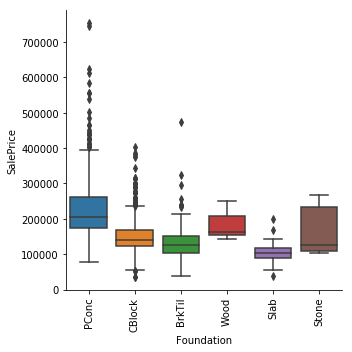

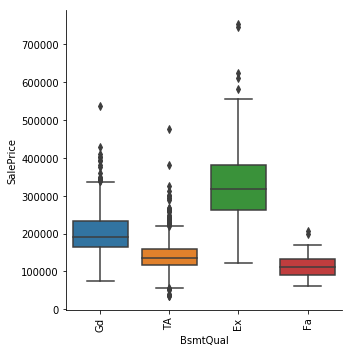

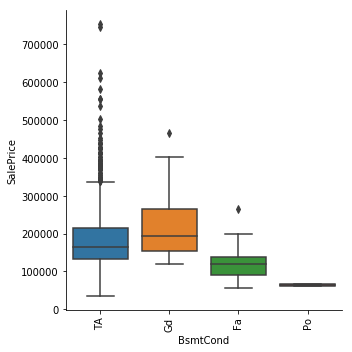

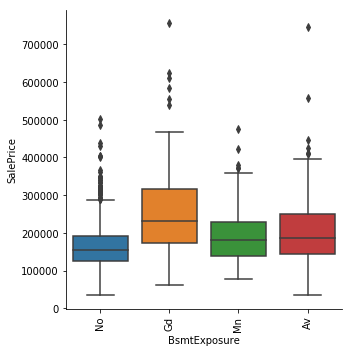

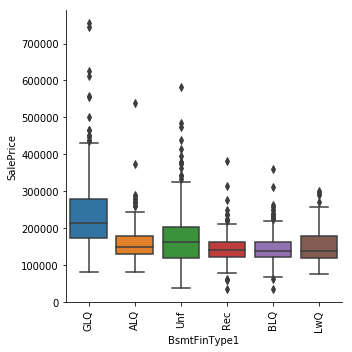

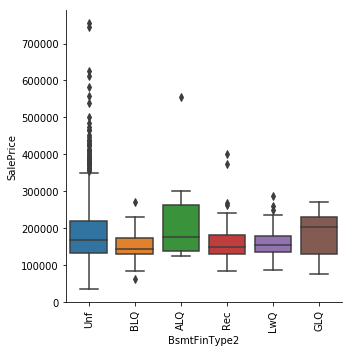

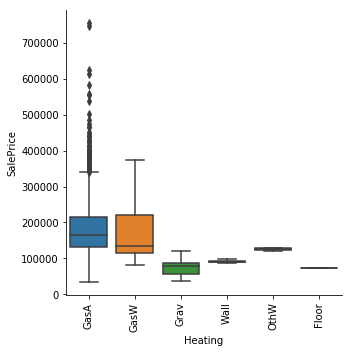

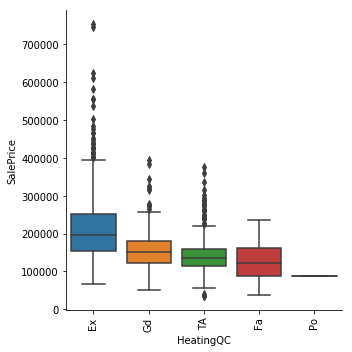

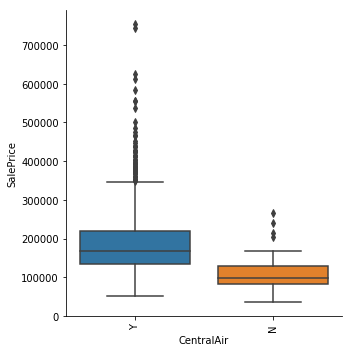

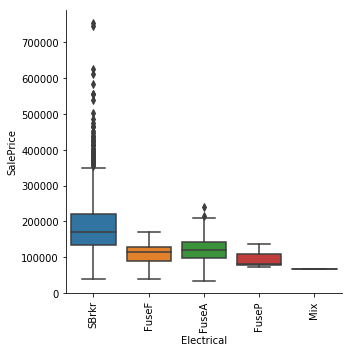

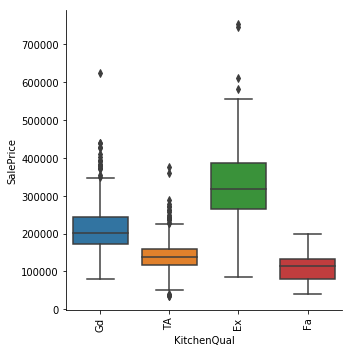

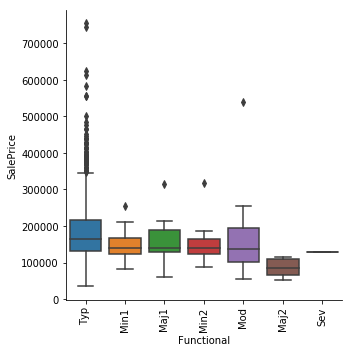

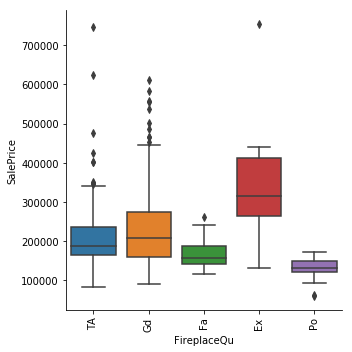

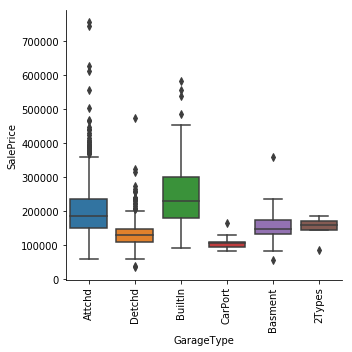

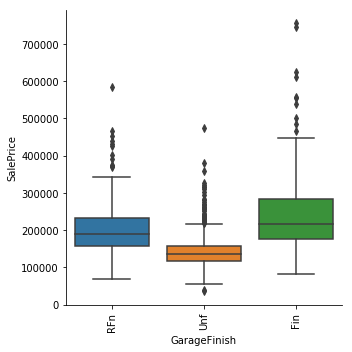

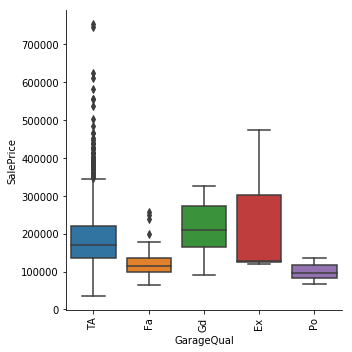

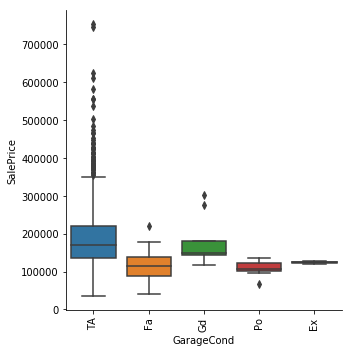

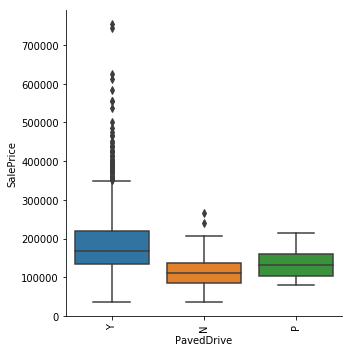

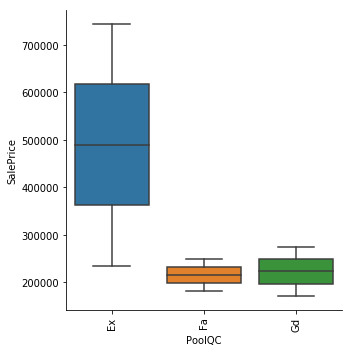

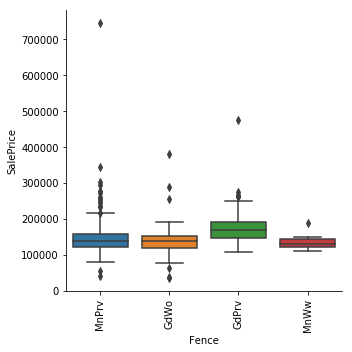

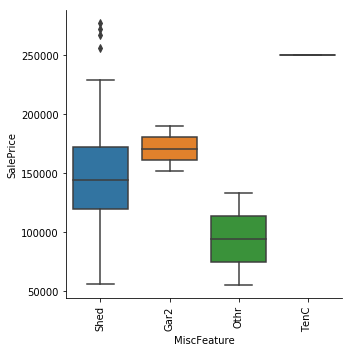

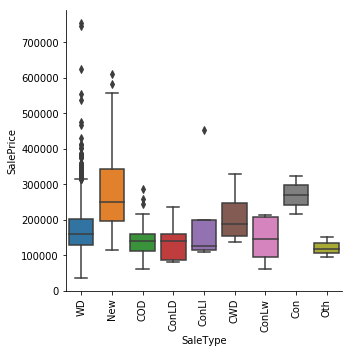

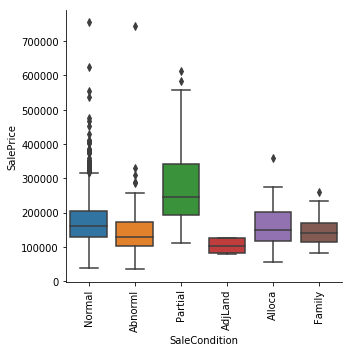

In [67]:
# Boxplot for categorical features vs House sale price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

for i in categorical_features:
    sns.FacetGrid(train_df, size=5).map(boxplot,i, "SalePrice")
plt.show()


In [69]:
#Features correction: dropping/filling Nans.
#Houses in the same Neighborhood will probably have similar LotFrontage     
train_df.LotFrontage=train_df.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
train_df=train_df[train_df.LotFrontage < 200]
train_df.MasVnrArea.fillna(0, inplace =True)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train_df[col] = train_df[col].fillna(0)
for col in ('Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','MiscFeature','PoolQC'):
    train_df[col] = train_df[col].fillna("None")
train_df['Electrical']=train_df.Electrical.fillna(train_df['Electrical'].mode()[0])
train_df['MasVnrType'] = train_df['MasVnrType'].fillna("None")
train_df["KitchenQual"] = train_df.loc[:, "KitchenQual"].fillna("TA")

test_df.LotFrontage=test_df.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
test_df.MasVnrArea.fillna(0, inplace =True)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea'):
    test_df[col] = test_df[col].fillna(0)
for col in ('Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','MiscFeature','PoolQC','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','Utilities'):
    test_df[col] = test_df[col].fillna("None")
test_df['MSZoning']=test_df.MSZoning.fillna(test_df['MSZoning'].mode()[0])
test_df['SaleType']=test_df.SaleType.fillna(test_df['SaleType'].mode()[0])
test_df['Exterior1st'] = test_df['Exterior1st'].fillna(test_df['Exterior1st'].mode()[0])
test_df['Exterior2nd'] = test_df['Exterior2nd'].fillna(test_df['Exterior2nd'].mode()[0])
test_df['MasVnrType'] = test_df['MasVnrType'].fillna("None")
test_df["Functional"] = test_df["Functional"].fillna("Typ")
test_df.loc[:, "KitchenQual"] = test_df.loc[:, "KitchenQual"].fillna("TA")

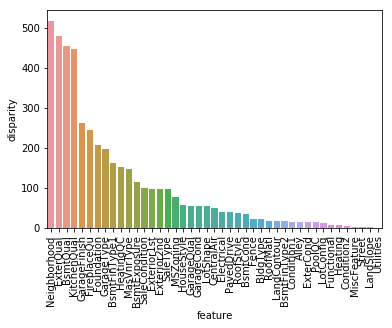

In [70]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = categorical_features
    pvals = []
    for c in categorical_features:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train_df)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

SalePrice        1.000
OverallQual      0.796
GrLivArea        0.735
TotalBsmtSF      0.652
GarageCars       0.641
1stFlrSF         0.632
GarageArea       0.629
FullBath         0.562
TotRmsAbvGrd     0.538
YearBuilt        0.524
YearRemodAdd     0.507
MasVnrArea       0.478
Fireplaces       0.470
BsmtFinSF1       0.409
LotFrontage      0.379
WoodDeckSF       0.325
OpenPorchSF      0.322
2ndFlrSF         0.321
HalfBath         0.285
LotArea          0.268
GarageYrBlt      0.261
BsmtFullBath     0.228
BsmtUnfSF        0.215
BedroomAbvGr     0.168
ScreenPorch      0.112
PoolArea         0.100
MoSold           0.045
3SsnPorch        0.045
BsmtFinSF2      -0.011
BsmtHalfBath    -0.017
MiscVal         -0.021
LowQualFinSF    -0.026
YrSold          -0.029
OverallCond     -0.079
MSSubClass      -0.084
EnclosedPorch   -0.128
KitchenAbvGr    -0.136
Name: SalePrice, dtype: float64


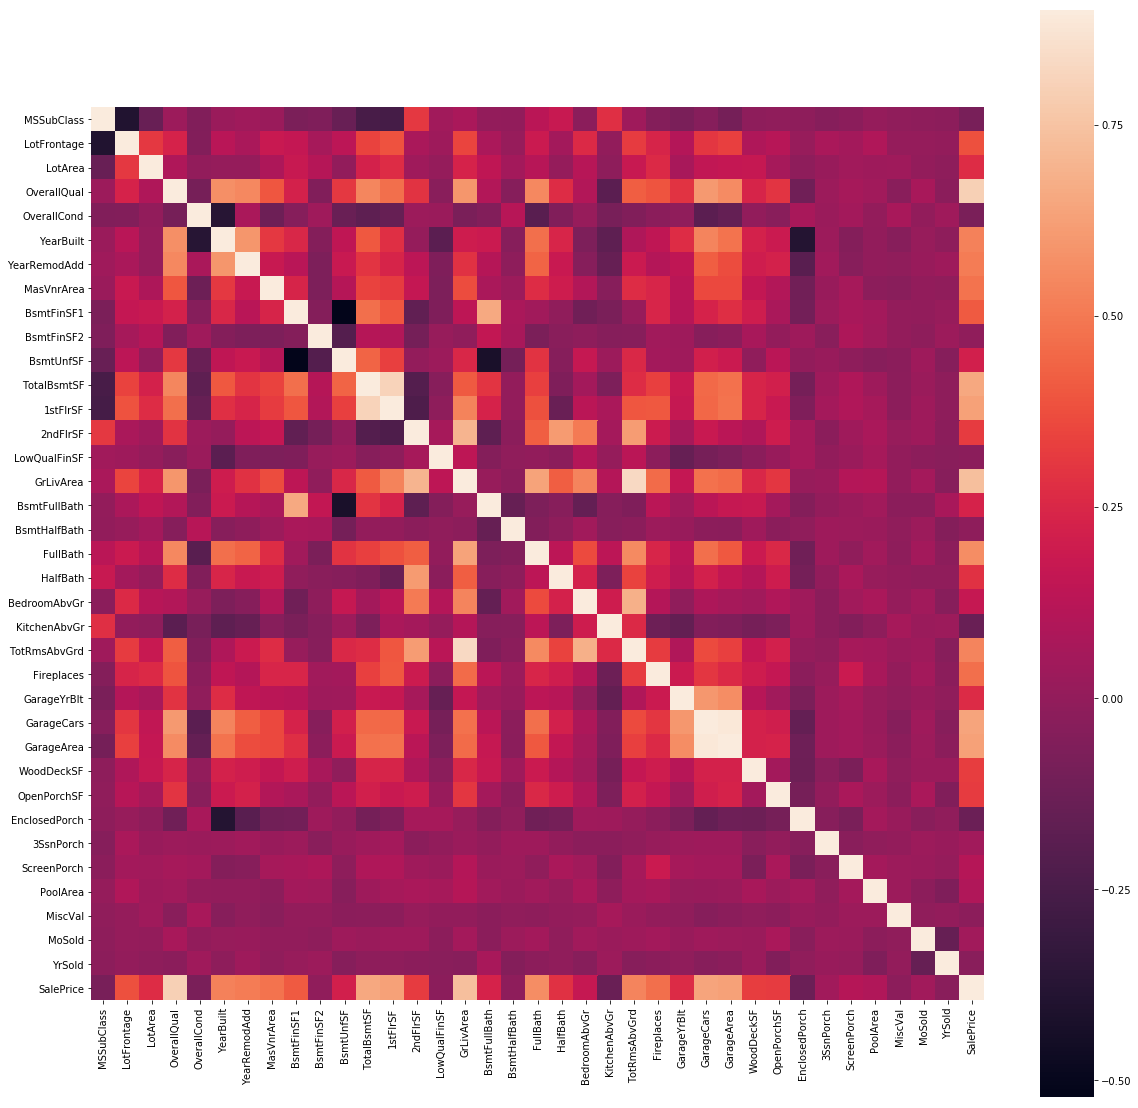

In [71]:
#Heatmap to identify correlation between features
plt.subplots(figsize=(20,20))
corr = train_df.corr()
sns.heatmap(corr,vmax=0.9, square=True)
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Identified correlations: OverallQual-SalePrice, GarageArea-GarageCars, TotRmsAbvGrd-GrLivArea TotalBsmtFinSF-1stFlrSF, GarageYrblt-GarageCond, kitchenQual-ExterQual


In [73]:
#converting categorical variables
#concatenating the training and testing dataset in one dataframe df
df=pd.concat([train_df,test_df])
#correcting categorical features
df["Alley"]=df["Alley"].map({"None": 0, "Grvl" : 1, "Pave" : 2}).astype(int)
df["BsmtCond"]=df["BsmtCond"].map({"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}).astype(int) 
df["BsmtExposure"]=df["BsmtExposure"].map({"None" : 0, "No" : 1, "Mn": 2, "Av" : 3, "Gd":4}).astype(int) 
df["BsmtFinType1"]=df["BsmtFinType1"].map({"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}).astype(int) 
df["BsmtFinType2"]=df["BsmtFinType2"].map({"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,"ALQ" : 5, "GLQ" : 6}).astype(int) 
df["BsmtQual"]=df["BsmtQual"].map({"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}).astype(int) 
df["ExterCond"]=df["ExterCond"].map({"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5}).astype(int) 
df["ExterQual"]=df["ExterQual"].map({"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5}).astype(int) 
df["FireplaceQu"]=df["FireplaceQu"].map({"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}).astype(int) 
df["Functional"]=df["Functional"].map({"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8}).astype(int)
df["GarageCond"]=df["GarageCond"].map({"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}).astype(int) 
df["GarageQual"]=df["GarageQual"].map({"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}).astype(int) 
df["HeatingQC"]=df["HeatingQC"].map({"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}).astype(int) 
df["KitchenQual"]=df["KitchenQual"].map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}).astype(int) 
df["LandSlope"]=df["LandSlope"].map({"Sev" : 1, "Mod" : 2, "Gtl" : 3}).astype(int) 
df["LotShape"]=df["LotShape"].map({"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4}).astype(int) 
df["PavedDrive"]=df["PavedDrive"].map({"N" : 0, "P" : 1, "Y" : 2}).astype(int)
df["PoolQC"]=df["PoolQC"].map({"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}).astype(int) 
df["Street"]=df["Street"].map({"Grvl" : 1, "Pave" : 2}).astype(int) 
df["Utilities"]=df["Utilities"].map({"None" : 0, "NoSeWa" : 1, "AllPub" : 2}).astype(int) 
df["BsmtHalfBath"]=df["BsmtHalfBath"].map({"None" : 0, 0 : 0, 1 : 1, 2:2}).astype(float)
df["BsmtFullBath"]=df["BsmtFullBath"].map({"None" : 0, 0 : 0, 1 : 1, 2:2, 3:3}).astype(int)
df["HalfBath"]=df["HalfBath"].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 0 to 1458
Data columns (total 80 columns):
1stFlrSF         2916 non-null int64
2ndFlrSF         2916 non-null int64
3SsnPorch        2916 non-null int64
Alley            2916 non-null int32
BedroomAbvGr     2916 non-null int64
BldgType         2916 non-null object
BsmtCond         2916 non-null int32
BsmtExposure     2916 non-null int32
BsmtFinSF1       2916 non-null object
BsmtFinSF2       2916 non-null object
BsmtFinType1     2916 non-null int32
BsmtFinType2     2916 non-null int32
BsmtFullBath     2916 non-null int32
BsmtHalfBath     2916 non-null float64
BsmtQual         2916 non-null int32
BsmtUnfSF        2916 non-null object
CentralAir       2916 non-null object
Condition1       2916 non-null object
Condition2       2916 non-null object
Electrical       2916 non-null object
EnclosedPorch    2916 non-null int64
ExterCond        2916 non-null int32
ExterQual        2916 non-null int32
Exterior1st      2916 non-null o

In [74]:
#Dropping Nans
df=df[df['TotalBsmtSF']!="None"]
df.TotalBsmtSF=df.TotalBsmtSF.astype(int)

In [75]:
#Correcting features that are strings
strCols = ['YrSold','YearRemodAdd','YearBuilt','MoSold','MSSubClass']
for i in strCols:
    df[i]=df[i].astype(str)

In [76]:
# Creations of new features from combinations of existing features
# Overall fireplace score
df["FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]    
    # Overall quality of the garage
df["GarageGrade"] = df['GarageQual'] * df["GarageCond"]
    #Total number of bathrooms
df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + df["FullBath"] + (0.5 * df["HalfBath"])
    # Total SF for house (incl. basement)
df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
    # Total SF for 1st + 2nd floors
df["AllFlrsSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    # Total SF for porch
df["AllPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
df.drop(columns = ['GarageCond',"GarageQual","BsmtFullBath","BsmtHalfBath","Fireplaces","FireplaceQu","FullBath","HalfBath",'BsmtFinSF1','BsmtFinSF2','GarageCars','GarageCond', 'GarageYrBlt',"GrLivArea", "TotalBsmtSF","1stFlrSF","2ndFlrSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"], inplace =True)

In [77]:
#LabelEncoding using Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder, Imputer
from scipy.stats import skew

# Label encoding class
class labenc(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        label = LabelEncoder()
        X['YrSold']=label.fit_transform(X['YrSold'])
        X['YearRemodAdd']=label.fit_transform(X['YearRemodAdd'])
        X['YearBuilt']=label.fit_transform(X['YearBuilt'])
        X['MoSold']=label.fit_transform(X['MoSold'])
        return X
# Skewness transform class
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
class skewness(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        skewness = X.select_dtypes(include=[np.number]).apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= 1].index
        X[skewness_features] = np.log1p(X[skewness_features])
        return X

# One hot encoding class
class onehotenc(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X = pd.get_dummies(X)
        return X

In [78]:
# Creating a copy of the full dataset
dataFullCopy = df.copy()

# Creating a new fata with aplied transformations using sklearn Pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('labenc',labenc()),('skewness',skewness()),('onehotenc',onehotenc())])
dataPipeline = pipeline.fit_transform(dataFullCopy)
df.shape, dataPipeline.shape

((2915, 66), (2915, 1364))

In [80]:
dataPipeline.head()

,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,ExterCond,ExterQual,Functional,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0.000,3,1.386,0.693,6,0.693,1.609,1.386,4,2.197,...,0,0,0,0,0,0,0,0,0,1
1,0.000,3,1.386,1.609,5,0.693,1.609,1.386,3,2.197,...,0,0,0,0,0,0,0,0,0,1
2,0.000,3,1.386,1.099,6,0.693,1.609,1.386,4,2.197,...,0,0,0,0,0,0,0,0,0,1
3,0.000,3,1.609,0.693,5,0.693,1.386,1.386,3,2.197,...,0,0,0,0,0,0,0,0,0,1
4,0.000,4,1.386,1.386,6,0.693,1.609,1.386,4,2.197,...,0,0,0,0,0,0,0,0,0,1


In [81]:
#splitting trainin and testind datsets
X_train = dataPipeline[:train_df.shape[0]]
y_train = X_train['SalePrice']
X_train.drop(columns = 'SalePrice', inplace=True)
X_test = dataPipeline[train_df.shape[0]:]
X_test.drop(columns = 'SalePrice', inplace=True)
X_train.shape, y_train.shape, X_test.shape

((1457, 1363), (1457,), (1458, 1363))

Transforming and Scaling

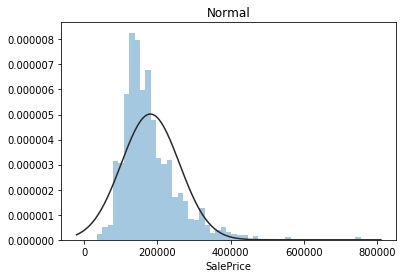

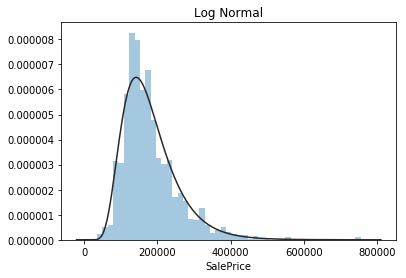

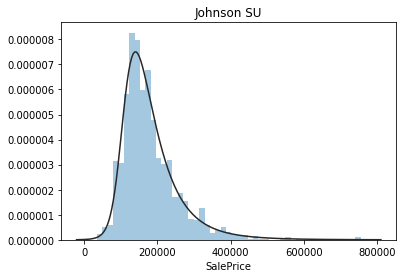

In [82]:
# SalesPrices plot with three different fitted distributions
plt.figure(2); plt.title('Normal')
sns.distplot(y_train, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y_train, kde=False, fit=stats.lognorm)
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y_train, kde=False, fit=stats.johnsonsu)

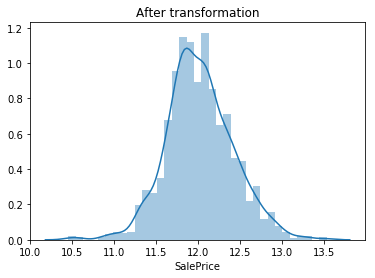

In [83]:
# transforming 'SalePrice' into normal distribution
y_train_transformed = np.log(y_train)
y_train_transformed.skew(), y_train_transformed.kurt()
plt.title('After transformation')
sns.distplot(y_train_transformed)

In [84]:
# Using Robust Scaler to transform X_train
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit(X_train).transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

Dimensionality reduction

In [85]:
from sklearn.decomposition import PCA
# Concatenate the training and test datasets into a single datafram
dataFull2 = np.concatenate([X_train_scaled,X_test_scaled])
# Choose the number of principle components such that 95% of the variance is retained
pca = PCA(0.95)
dataFull2 = pca.fit_transform(dataFull2)
varPCA = np.round(pca.explained_variance_ratio_*100, decimals = 1)
# Principal Component Analysis of data
print(varPCA)

[21.5  8.3  5.6  5.3  4.6  3.5  3.4  2.6  2.2  2.   1.8  1.8  1.6  1.5
  1.4  1.4  1.3  1.2  1.   1.   0.9  0.9  0.8  0.8  0.7  0.7  0.7  0.7
  0.6  0.6  0.6  0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.4  0.4  0.4  0.4
  0.4  0.4  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.2  0.2
  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


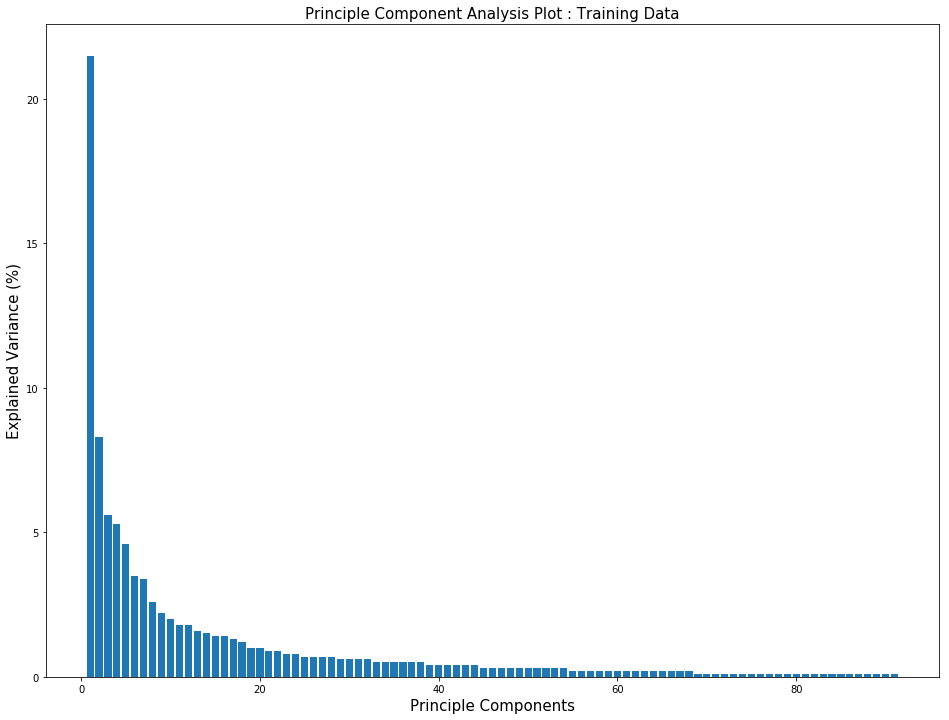

In [86]:
plt.figure(figsize=(16,12))
plt.bar(x=range(1,len(varPCA)+1), height = varPCA)
plt.ylabel("Explained Variance (%)", size = 15)
plt.xlabel("Principle Components", size = 15)
plt.title("Principle Component Analysis Plot : Training Data", size = 15)
plt.show()

<a id='model'></a>
### Model, predict and solve the problem
Now I will focus on answering the questions for this challenge through use of machine learning tools.
In this section I will test different machine learning algorythm and check which one perform better based on Residual Mena Squared Error (RMSE)
 

In [87]:
X_train_scaled = dataFull2[:train_df.shape[0]]
X_test_scaled = dataFull2[train_df.shape[0]:]
X_train_scaled.shape, y_train_transformed.shape, X_test_scaled.shape

((1457, 91), (1457,), (1458, 91))

In [88]:
models = [LinearRegression(),
             SVR(),
             SGDRegressor(),
             SGDRegressor(max_iter=1000, tol = 1e-3),
             GradientBoostingRegressor(n_estimators=1000),
             RandomForestRegressor(n_estimators=1000),
             Lasso(),
             Lasso(alpha=0.01,max_iter=10000),
             Ridge(),
             BayesianRidge(),
             KernelRidge(),
             KernelRidge(alpha=0.6,kernel='polynomial',degree = 2,coef0=2.5),
             ElasticNet(),
             ElasticNet(alpha = 0.001,max_iter=10000),    
             ExtraTreesRegressor(),
             ]
names = ['Linear regression','Support vector regression','Stochastic gradient descent','Stochastic gradient descent 2','Gradient boosting tree','Random forest','Lasso regression','Lasso regression 2','Ridge regression','Bayesian ridge regression','Kernel ridge regression','Kernel ridge regression 2','Elastic net regularization','Elastic net regularization 2','Extra trees regression']

In [89]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)
def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

def rmse(model,X,y):
    rmse = np.sqrt(-cross_val_score(model,X,y,scoring="neg_mean_squared_error",cv=5))
    return rmse

# Look at predictions on training and validation set


for model, name in zip(models, names):
    # Root mean square error
    score = rmse(model,X_train_scaled,y_train_transformed)
    print("- {} : mean : {:.6f}, std : {:4f}".format(name, score.mean(),score.std()))

- Linear regression : mean : 0.118422, std : 0.006902
- Support vector regression : mean : 0.121394, std : 0.005789
- Stochastic gradient descent : mean : 0.207529, std : 0.026543
- Stochastic gradient descent 2 : mean : 0.156797, std : 0.016888
- Gradient boosting tree : mean : 0.125252, std : 0.003184
- Random forest : mean : 0.147210, std : 0.005203
- Lasso regression : mean : 0.399515, std : 0.015973
- Lasso regression 2 : mean : 0.137577, std : 0.005464
- Ridge regression : mean : 0.118269, std : 0.006868
- Bayesian ridge regression : mean : 0.117509, std : 0.006671
- Kernel ridge regression : mean : 12.829229, std : 0.200759
- Kernel ridge regression 2 : mean : 0.113248, std : 0.005808
- Elastic net regularization : mean : 0.278675, std : 0.015102
- Elastic net regularization 2 : mean : 0.117492, std : 0.006334
- Extra trees regression : mean : 0.151233, std : 0.008362


Kernel ridge regression 2 : mean : 0.113248, std : 0.005808 looks to be the model performing better